## #1. Learning Dynamics in Deep Linear Networks - Luke Longren & Sujitkumar Gavali

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (12,9)

## Exercise 1: Singular Value Mode Convergence

### 1. Implement the mean weight update equations in the continuous time limit using forward Euler integration and setting ∆t = 0.1:

In [3]:
# Writing the forward Euler integration function
def forward_euler(function, y0, T, dt):
    y = np.zeros(int(T/dt))
    y[0] = y0
    for n in range(int(T/dt-1)):
        y[n+1] = y[n] + (dt * function(y)[n])
    return y

### <font color=black> $ \tau \frac{d}{dt} W^1 = W^{2^T} (\sum^{yx} - W^2  W^1 \sum^x), \ $  Single-hidden layer linear network

In [4]:
def derivative_W1(tau, W1, W2, W2T, sum_x, sum_yx):
    return (1/tau) * W2T * (sum_yx - W2 * W1 * sum_x)

### <font color=black> $ \tau \frac{d}{dt} W^2 = (\sum^{yx} - W^2  W^1 \sum^x) W^{1^T}, \ $  "Shallow" network

In [5]:
def derivative_W2(tau, W1, W2, W1T, sum_x, sum_yx):
    return (1/tau) * (sum_yx - W2 * W1 * sum_x) * W1T

### 2. Perform weight updates for the given $Σx$ and $Σyx$ and Gaussian initialised weight matrices. Set the time constant $τ = 1/η$ with learning rate $η = 0.4$ and $T = 15$. After each update of the weight matrices compute the SVD. Plot the dynamics of the singular value modes $aα(t)$and compare them to the singular values sα of the covariance matrix $Σyx$. What can you observe?

In [6]:
X=np.identity(4) #Inputs

In [7]:
W1_input=np.zeros(64) #weights between the input layer and the hidden layer
W1=W1_input.reshape(16,4)

W2_input=np.zeros(112) #weights between the hidden layer and the output
W2=W2_input.reshape(7,16)

In [8]:
#Q2

eta=0.4
tau=1/eta
T=15

# weight_update_X= W1*X

# weight_update_Y= W2*weight_update_X

# Gaussian_weight_update_1= np.std(np.mean(W1)) * X


# Gaussian_weight_update_2=np.std(np.mean(W2)) * Y

# Sigma_YX= Gaussian_weight_update_1 * Gaussian_weight_update_2


# SVD=np.linalg.svd(Sigma_YX)

### 3. Implement the analytic solutions for the singular value mode dynamics. Compute the analytical values of the singular values by setting $a^0_α = b^0_α = 0.001$. Again, plot them for the different time steps and compare them to the empirical ones calculated in the previous part. How well do theory and simulation align?

### <font color=black> $ a_\alpha (t) = \frac{s_\alpha e^{2 s_\alpha t/\tau}}{e^{2 s_\alpha t /\tau} - 1 + s_\alpha / a^{0}_{\alpha}}, \$ analytical single-hidden layer linear network

### <font color=black> $ b_\alpha (t) = s_\alpha (1 - e^{-t/\tau}) + b_{\alpha}^0 e^{-t/\tau}, \$ analytical "shallow" network

In [9]:
def analytical_single_hidden(t, s, a, tau):
    num = s * np.exp(2*s*t/tau)
    den = np.exp(2*s*t/tau) - 1 + s/a
    return num/den

In [10]:
def analytical_shallow(t, s, b, tau):
    b = s * (1 - np.exp(-t/tau)) + b * np.exp(-t/tau)
    return b

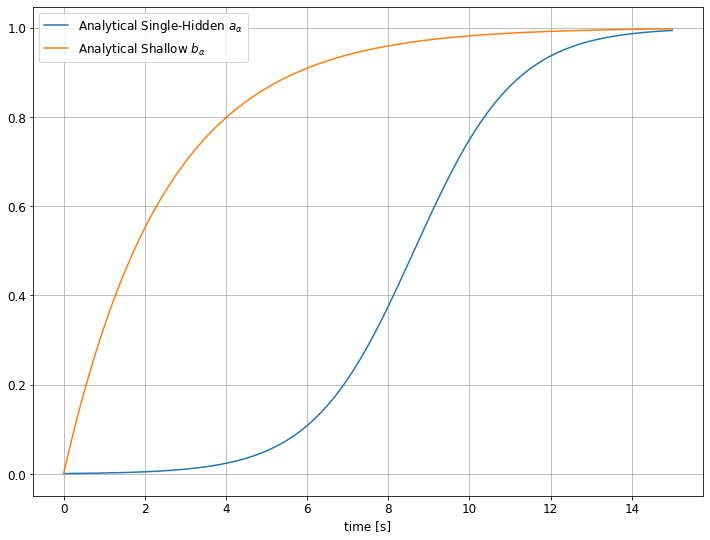

In [11]:
# Plot the networks
t = np.linspace(0, 15, 15//0.1)

#didn't finish the second problem, but setting s=1 to see a slice of the dynamics
plt.plot(t, analytical_single_hidden(t=t, s=1, a=0.001, tau=1/0.4), label=r'Analytical Single-Hidden $a_\alpha$')
plt.plot(t, analytical_shallow(t=t, s=1, b=0.001, tau=1/0.4), label=r'Analytical Shallow $b_\alpha$')
plt.xlabel('time [s]')
plt.legend()
plt.grid()
plt.show()

## Exercise 2: Deeper (Non-) Linear Networks with AutoDiff

In [12]:
import numpy as np
from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

np.random.seed(1)

In [13]:
class DiffuseTreeSampler():
    def __init__(self, target_dim, tree_depth, branching_factor, sample_epsilon):
        self.target_dim = target_dim
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_target(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        target_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(target_tree[-1], self.branching_factor)
            target_tree.append(next_layer*switch)
        return target_tree[-1]
    
    def sample_data(self):
        """
        Each target dimension diffuses independently of the others!
        """
        targets = []
        for tar in range(self.target_dim):
            target_temp = self.sample_target()
            targets.append(target_temp)
        
        targets_out = np.array(targets).T
        features_out = np.diag(np.ones(self.num_examples))
        return targets_out, features_out

In [14]:
data_set_sampling = DiffuseTreeSampler(target_dim=100, tree_depth=3, branching_factor=4, sample_epsilon=0.5)
targets, features = data_set_sampling.sample_data()

# print("Output Dimensions: {}".format(targets.shape))
# print("Input Dimensions: {}".format(features.shape))

In [15]:
# Calculate the SVD of the covariance matrix
SIGMA_YX = targets.T @ features
U, s, V = svd(SIGMA_YX, full_matrices=True)

### 1. Code a variable depth Deep Linear Network class that takes as an input a list of hidden units for each layer.

In [16]:
# TODO: Generalize to variable depth
class DeepLinearNet(nn.Module):
    """
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim, output_dim, hidden_units):
        super(DeepLinearNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        layers["in-hidden"] = nn.Linear(input_dim, hidden_units[0], bias=False)
        # TODO: Loop over the hidden layers in the middle to define the full network architecture!
        for lvl in range(len(hidden_units)):
            layers["in-hidden-activation %i" %lvl] = nn.ReLU()
        layers["hidden-out"] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [17]:
hidden_units = [16, 32, 32, 16]

# input_dim, output_dim = 64, 100
input_dim, output_dim = features.shape[1], targets.shape[1]

l_rate = 0.5
relu_net = DeepLinearNet(input_dim, output_dim, hidden_units)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=l_rate)

mse_loss = nn.MSELoss()

print("The Network Architecture")
print(relu_net)

The Network Architecture
DeepLinearNet(
  (model): Sequential(
    (in-hidden): Linear(in_features=64, out_features=16, bias=False)
    (in-hidden-activation 0): ReLU()
    (in-hidden-activation 1): ReLU()
    (in-hidden-activation 2): ReLU()
    (in-hidden-activation 3): ReLU()
    (hidden-out): Linear(in_features=16, out_features=100, bias=False)
  )
)


### a) Shuffle the data ordering at the beginning of each epoch.

### b) Perform the forward pass at each iteration for a selected feature, target pair.

### c) Calculate the corresponding loss using the Mean Squared Error (MSE) Loss.

### d) Reset the parameter gradients, perform a backwards pass to calculate the current gradients & update the parameters with the help of an optimizer object.

In [18]:
# TODO: Define the Online Gradient Descent Training Loop
def linear_net_learning(deep_net, mse_loss, optimizer, num_epochs, features, targets):
    """
    Inputs: 'deep_net'   - Instantiated PyTorch Network
            'mse_loss'   - Loss Criterion, i.e. Mean Squared Error
            'optimizer'  - PyTorch Optimizer Object, i.e. Stochastic Gradient Descent
            'num_epochs' - Number of Training Loops over the entire dataset
            'features'   - Training features generated from the sampler
            'targets'    - Training targets generated from the sampler
    Function: Runs the learning loop for the linear network
    """
    loss_log = []
    log_singular_vals = []
    num_points = targets.shape[0]
    y_hat_collection = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        # TODO: Reshuffle the order of the dataset
        train_items = targets
        train_features = features
        np.random.shuffle([train_items, train_features])
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            # Extract the current training datapoint and transform it into a Torch Tensor
            input_tensor = torch.tensor(train_items[t])
            y_true = torch.tensor(train_features[t]).float()
                
            # TODO: Compute the prediction for the single datapoint y^hat & the corresponding loss
            y_hat = deep_net(input_tensor)
            loss = mse_loss(y_hat, y_true)
            
            # TODO: Clear the gradients, Perform the backward pass, and SGD update
            deep_net.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the epoch loss tracker
            epoch_loss += loss.item()
        
        # Log the mean epoch loss & calculate the SVD
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(features)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

### 3. Create a dataset by creating an instance of DiffuseTreeSampler() and sampling from it. Afterwards, compute the SVD of $\sum^{yx}$ and assert that $\sum^{x} = 1$. Train a deep linear network:

### a) Define a linear network with three hidden layers.

In [19]:
hidden_units = [64, 128, 64]
'''Here should be a hidden units of [64, 128, 128], but we kept running into 
    a shape error with the third unit not matching the size of the first.
    Is this caused by an error elsewhere that we are missing?'''
input_dim, output_dim = 64, 64
# input_dim, output_dim = features.shape[1], targets.shape[1]

### b) Instantiate an Stochastic Gradient Descent optimizer object with learning rate η = 0.5.

In [20]:
l_rate = 0.5
relu_net = DeepLinearNet(input_dim, output_dim, hidden_units)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=l_rate)

# print(relu_net)
# print(relu_optimizer)

### c) Define the MSE loss function.

In [21]:
mse_function = nn.MSELoss()

data_set_sampling = DiffuseTreeSampler(target_dim=64, tree_depth=3, branching_factor=4, sample_epsilon=0.5)
targets, features = data_set_sampling.sample_data()

# Perform a pass through the network and calculate the loss
input_tensor = torch.tensor(features[0])
y_true = torch.tensor(targets[0]).float()
y_hat = relu_net(input_tensor)
loss = mse_function(y_hat, y_true)

print("The MSE Loss for the 1st datapoint:{:.3f}".format(loss))  

The MSE Loss for the 1st datapoint:1.001


### d) Run the linear_net_learning() loop for 1000 epochs.

In [22]:
loss_log, sing_vals_linear, = linear_net_learning(deep_net=relu_net, mse_loss=mse_function, optimizer=relu_optimizer, 
                                          num_epochs=1000, features=features, targets=targets)

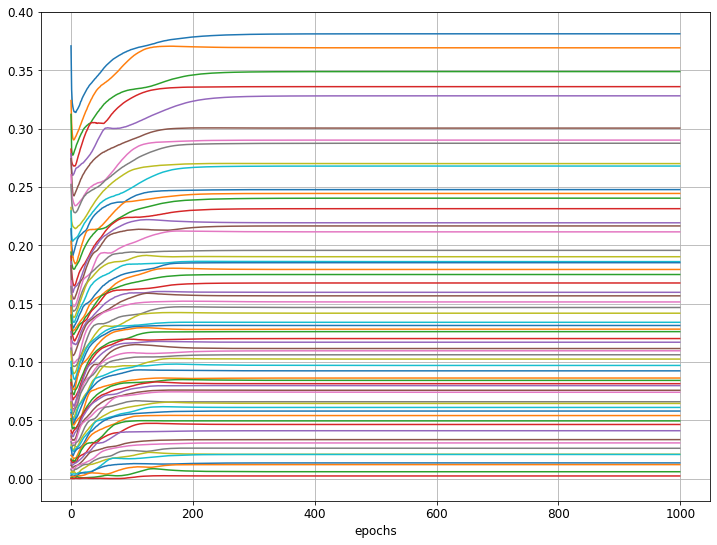

In [23]:
# TODO: Plot the singular values
plt.plot(sing_vals_linear)
# plt.plot(loss_log)
plt.xlabel('epochs')
plt.grid()
plt.show()

### 4. Do the results hold up for both deep linear and non-linear networks? Implement a ReLU activation after every linear layer. Which singular values converge first?


In [24]:
# TODO: Define a new network class that adds a ReLU activation function after each layer.
class DeepNonlinearNet(nn.Module):
    """
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, hidden_units, input_dim=64, output_dim=100):
        super(DeepLinearNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        layers["in-hidden"] = nn.Linear(input_dim, hidden_units[0], bias=False)
        # TODO: Loop over the hidden layers in the middle to define the full network architecture!
        layers["in-hidden-activation"] = nn.ReLU()
        layers["hidden-out"] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [25]:
def nonlinear_net_learning(deep_net, mse_loss, optimizer, num_epochs, features, targets):
    """
    Inputs: 'deep_net'   - Instantiated PyTorch Network
            'mse_loss'   - Loss Criterion, i.e. Mean Squared Error
            'optimizer'  - PyTorch Optimizer Object, i.e. Stochastic Gradient Descent
            'num_epochs' - Number of Training Loops over the entire dataset
            'features'   - Training features generated from the sampler
            'targets'    - Training targets generated from the sampler
    Function: Runs the learning loop for the linear network
    """
    loss_log = []
    log_singular_vals = []
    num_points = targets.shape[0]

    for epoch in range(num_epochs):
        epoch_loss = 0
        # TODO: Reshuffle the order of the dataset
        train_items = targets
        np.random.shuffle(train_items)
        train_features = features
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            # Extract the current training datapoint and transform it into a Torch Tensor
            input_tensor = torch.tensor(train_items[t])
            y_true = torch.tensor(train_features[t]).float()
                
            # TODO: Compute the prediction for the single datapoint y^hat & the corresponding loss
            y_hat = deep_net(input_tensor)
            loss = mse_loss(y_hat, y_true)
            
            # TODO: Clear the gradients, Perform the backward pass, and SGD update
            deep_net.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the epoch loss tracker
            epoch_loss += loss.item()
        
        # Log the mean epoch loss & calculate the SVD
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(features)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

In [26]:
# TODO: Instantiate the network, define the loss & optimizer and run the learning loop
hidden_units = [64, 64, 64]
input_dim, output_dim = 64, 64

l_rate = 0.5
relu_net = DeepNonlinearNet(input_dim, output_dim, hidden_units)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=l_rate)

mse_function = nn.MSELoss()

data_set_sampling = DiffuseTreeSampler(target_dim=64, tree_depth=3, branching_factor=4, sample_epsilon=0.5)
targets, features = data_set_sampling.sample_data()

# Perform a pass through the network and calculate the loss
input_tensor = torch.tensor(features[0])
y_true = torch.tensor(targets[0]).float()
y_hat = relu_net(input_tensor)
loss = mse_function(y_hat, y_true)

loss_log, sing_vals = nonlinear_net_learning(deep_net=relu_net, mse_loss=mse_function, optimizer=relu_optimizer, 
                                             num_epochs=1000, features=features, targets=targets)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
# TODO: Plot the singular values
plt.plot(sing_vals)
plt.grid()
plt.show()

Not exactly sure how to implement the nonlinear method. Where does the ReLU activation go? Not understanding 'between the linear layers' very well.

Although everything was not fully implemented, I would assume that with the extra computation between the linear layers, the nonlinear deep network would converge to the single values more quickly than the fully linear network.